# Quantium VI  
# Task 1 - Data Cleaning and Exploration

In [29]:
import pandas as pd
import numpy as np
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import spacy
import string
import en_core_web_sm
from sklearn.feature_extraction.text import TfidfVectorizer
import re
import pickle
from collections import Counter
from math import sqrt
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules

nlp = en_core_web_sm.load()
stopwords = spacy.lang.en.stop_words.STOP_WORDS
punctuations = string.punctuation
sns.set_theme()

## Transaction data

In [2]:
transaction_df_original = pd.read_excel('data/QVI_transaction_data.xlsx')

In [ ]:
transaction_df = transaction_df_original.copy()

In [20]:
transaction_df.describe()

,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_QTY,TOT_SALES
count,264836.000000,264836.00000,2.648360e+05,2.648360e+05,264836.000000,264836.000000,264836.000000
mean,43464.036260,135.08011,1.355495e+05,1.351583e+05,56.583157,1.907309,7.304200
std,105.389282,76.78418,8.057998e+04,7.813303e+04,32.826638,0.643654,3.083226
min,43282.000000,1.00000,1.000000e+03,1.000000e+00,1.000000,1.000000,1.500000
25%,43373.000000,70.00000,7.002100e+04,6.760150e+04,28.000000,2.000000,5.400000
50%,43464.000000,130.00000,1.303575e+05,1.351375e+05,56.000000,2.000000,7.400000
75%,43555.000000,203.00000,2.030942e+05,2.027012e+05,85.000000,2.000000,9.200000
max,43646.000000,272.00000,2.373711e+06,2.415841e+06,114.000000,200.000000,650.000000


In [29]:
transaction_df.head()

,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES
0,2018-10-17,1,1000,1,5,Natural Chip Compny SeaSalt175g,2,6.0
1,2019-05-14,1,1307,348,66,CCs Nacho Cheese 175g,3,6.3
2,2019-05-20,1,1343,383,61,Smiths Crinkle Cut Chips Chicken 170g,2,2.9
3,2018-08-17,2,2373,974,69,Smiths Chip Thinly S/Cream&Onion 175g,5,15.0
4,2018-08-18,2,2426,1038,108,Kettle Tortilla ChpsHny&Jlpno Chili 150g,3,13.8


### Missing values
Which columns have missing values? none apparently.

In [5]:
transaction_df.columns[transaction_df.isnull().any()].tolist()

[]

### Type inconsistencies

In [6]:
transaction_df.PROD_NBR.value_counts()

102    3304
108    3296
33     3269
112    3268
75     3265
       ... 
11     1431
76     1430
98     1419
29     1418
72     1410
Name: PROD_NBR, Length: 114, dtype: int64

What kind of inconsistencies are we looking for? the data is organised in a way that each row is a sale, divided by product.
- if product ID is unique per product name, than they are redundant and I only need one for analysis;

#### Date format
Date is reported as an integer rather than a date format. The real date can be obtained by adding the number of days to the date 30/12/1899, which is sometimes used as standard start date.

### Exploratory analysis
#### Total sales over time
There are three time intervals with clear outliers in total sales, with an approximate shift from the average value of 20%. This is seen in the total sales time series plot and in the box plot. It might be realted to occurrences on the calendar, and it would be interesting to see if is correlated with other factors. Actions:
- remove outliers;
- analyse outliers to see if they correlate with certain items, or customers.

To do that, I am identifying the DATE IDs that correspond to outliers, extracting them and saving them into another dataframe.

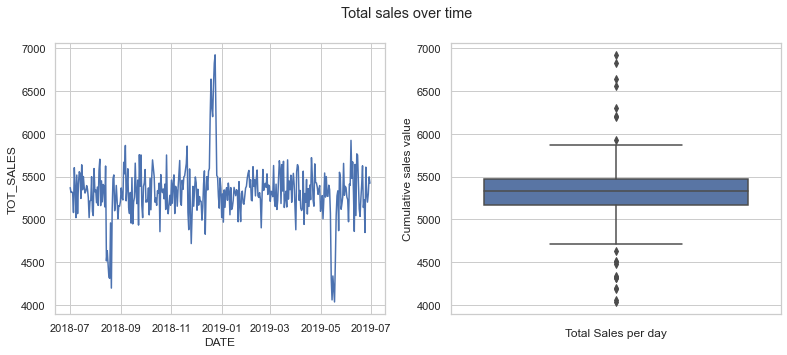

In [22]:
fig, axes = plt.subplots(1, 2, figsize=(13,5))
fig.suptitle('Total sales over time')
# Sales over time
S_o_T_df = transaction_df[['DATE','PROD_QTY','TOT_SALES']]
S_o_T_df = S_o_T_df.groupby(['DATE'], as_index=False).sum()
sns.set_style("whitegrid")
sns.lineplot(ax=axes[0],data = S_o_T_df,x = 'DATE', y = 'TOT_SALES')

data = S_o_T_df
sns.boxplot(ax=axes[1],data=data['TOT_SALES'], palette="deep").set(
    xlabel='Total Sales per day', 
    ylabel='Cumulative sales value',
    xticklabels=[])
plt.show()

#### Number of items sold over time
As expected, PROD_QTY mirrors TOT_SALES regarding outliers and shape. This is not necessarily true, for instance in case of large sales of very cheap or very expensive items.

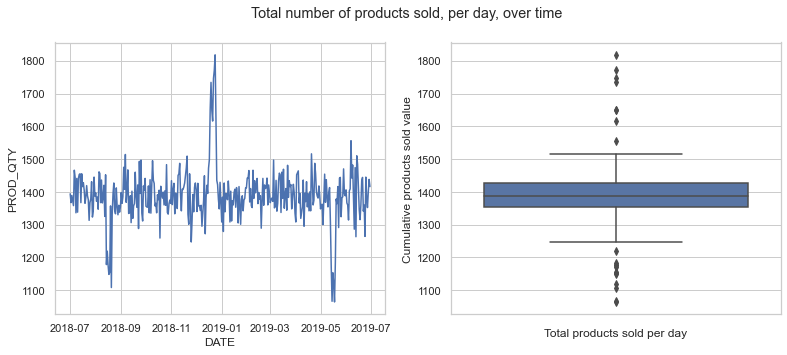

In [9]:
fig, axes = plt.subplots(1, 2, figsize=(13,5))
fig.suptitle('Total number of products sold, per day, over time')

sns.set_style("whitegrid")
sns.lineplot(ax=axes[0],data = S_o_T_df,x = 'DATE', y = 'PROD_QTY')

data = S_o_T_df
sns.boxplot(ax=axes[1],data=data['PROD_QTY'], palette="deep").set(
    xlabel='Total products sold per day', 
    ylabel='Cumulative products sold value',
    xticklabels=[])
plt.show()

In [33]:
print('There are',len(S_o_T_df), 'dates in the data. The first date is',min(S_o_T_df.DATE),', the last one is',max(S_o_T_df.DATE))

There are 364 dates in the data. The first date is 2018-07-01 00:00:00 , the last one is 2019-06-30 00:00:00


**ANALYSIS**  
We can see that the data frame has 364 date rows, so one is missing. We can look for it by comparing the available dates with a series containing all the dates from the interval considered.

In [48]:
base = min(S_o_T_df.DATE)
date_list = [base + datetime.timedelta(days=x) for x in range(365)]

In [60]:
for date in date_list:
    if date not in S_o_T_df.DATE.to_list():
        print('The missing date is:',date)

The missing date is: 2018-12-25 00:00:00


The missing date is Christmas, probably due to shops being closed.

We can use descriptive statistics to identify outliers and store the values in a data structure. By looking at the dates, we can see that the outliers are:
- days right before Christmas;
- 7/6/2019, a Friday; not sure if relevant, or just a random fluctuation;
- mid August 2018: possibly affected by summer holidays?;
- 14 to 19/5/2019;

In [23]:
TOT_SALES_IQR = S_o_T_df['TOT_SALES'].quantile(0.75) - S_o_T_df['TOT_SALES'].quantile(0.25)
HIGH_TOT_SALES_df = S_o_T_df[S_o_T_df['TOT_SALES'] > S_o_T_df['TOT_SALES'].quantile(0.75) + 1.5*TOT_SALES_IQR]
LOW_TOT_SALES_df = S_o_T_df[S_o_T_df['TOT_SALES'] < S_o_T_df['TOT_SALES'].quantile(0.25) - 1.5*TOT_SALES_IQR]
Outlier_dates_df = pd.concat([HIGH_TOT_SALES_df, LOW_TOT_SALES_df], ignore_index=True)

In [24]:
Outlier_dates_df

,DATE,PROD_QTY,TOT_SALES
0,2018-12-18,1651,6209.60
1,2018-12-19,1734,6639.80
2,2018-12-20,1649,6300.80
3,2018-12-21,1616,6201.30
4,2018-12-22,1746,6558.70
5,2018-12-23,1771,6826.00
6,2018-12-24,1818,6923.00
7,2019-06-07,1556,5924.10
8,2018-08-14,1178,4516.25
9,2018-08-15,1219,4634.80


#### Sales per store number, and per loyalty card (i.e. per customer)
It is also important to see how sales are distributed over different stores. It doesn't look like there is any outlier that needs removing.

As regards the sales per customer, identified through their loyalty card number, the distribution has outliers that can be cleaned out.

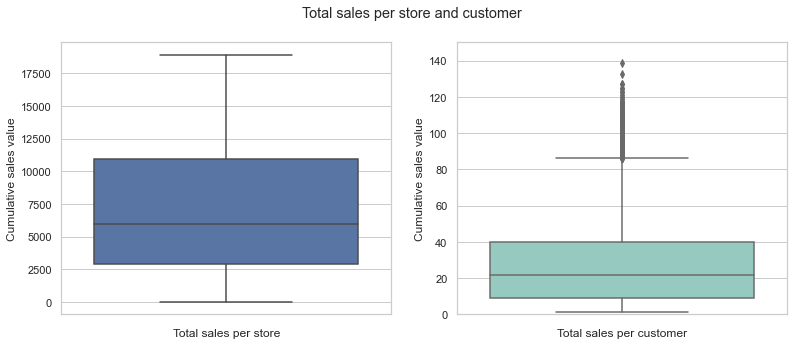

In [62]:
S_STORE_NBR_df = transaction_df[['STORE_NBR','TOT_SALES']]
S_STORE_NBR_df = S_STORE_NBR_df.groupby(['STORE_NBR'], as_index=False).sum()

LYLTY_CARD_NBR_df = transaction_df[['LYLTY_CARD_NBR','TOT_SALES']]
LYLTY_CARD_NBR_df = LYLTY_CARD_NBR_df.groupby(['LYLTY_CARD_NBR'], as_index=False).sum()


fig, axes = plt.subplots(1,2,figsize=(13,5))
fig.suptitle('Total sales per store and customer')

sns.set_style("whitegrid")

sns.boxplot(ax=axes[0],data=S_STORE_NBR_df['TOT_SALES'], palette="deep").set(
    xlabel='Total sales per store', 
    ylabel='Cumulative sales value',
    xticklabels=[])


sns.boxplot(ax=axes[1],data=LYLTY_CARD_NBR_df['TOT_SALES'], palette="Set3").set(
    xlabel='Total sales per customer', 
    ylabel='Cumulative sales value',
    xticklabels=[])
plt.ylim(0, 150)
plt.show()

In [63]:
LYLTY_CARD_NBR_df_SALES_IQR = LYLTY_CARD_NBR_df['TOT_SALES'].quantile(0.75) - LYLTY_CARD_NBR_df['TOT_SALES'].quantile(0.25)
Outlier_LYLTY_CARD_NBR_df = LYLTY_CARD_NBR_df[LYLTY_CARD_NBR_df['TOT_SALES'] > LYLTY_CARD_NBR_df['TOT_SALES'].quantile(0.75) + 1.5*LYLTY_CARD_NBR_df_SALES_IQR]

#### Sales per product number
There does not seem to be any outlier here, and the product quantity variable looks beautifully balanced. The Total sales plot probably reflects the product prices distribution.

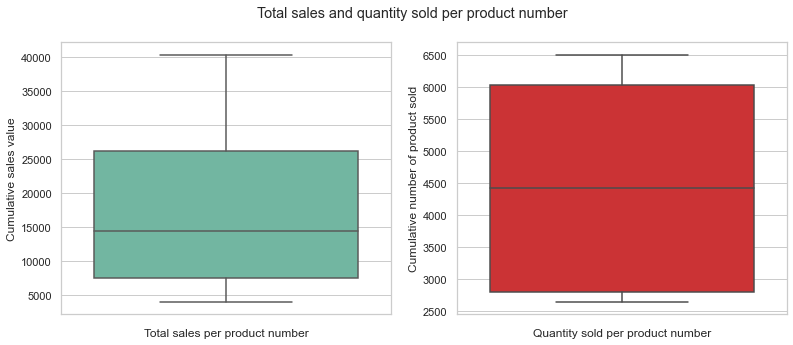

In [64]:
S_PROD_NBR_df = transaction_df[['PROD_NBR','PROD_QTY','TOT_SALES']]
S_PROD_NBR_df = S_PROD_NBR_df.groupby(['PROD_NBR'], as_index=False).sum()

fig, axes = plt.subplots(1,2,figsize=(13,5))
fig.suptitle('Total sales and quantity sold per product number')

sns.set_style("whitegrid")

sns.boxplot(ax=axes[0],data=S_PROD_NBR_df['TOT_SALES'], palette="Set2").set(
    xlabel='Total sales per product number', 
    ylabel='Cumulative sales value',
    xticklabels=[])


sns.boxplot(ax=axes[1],data=S_PROD_NBR_df['PROD_QTY'], palette="Set1").set(
    xlabel='Quantity sold per product number', 
    ylabel='Cumulative number of product sold',
    xticklabels=[])
plt.show()

#### Individual sale instances
Here we are checking if there is any abnormal sale, in terms of quantity or money spent.

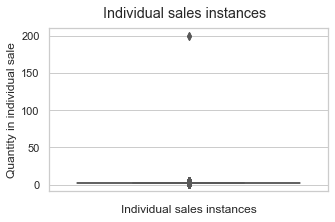

In [65]:
fig, axes = plt.subplots(1,1,figsize=(5,3))
fig.suptitle('Individual sales instances')

sns.set_style("whitegrid")

sns.boxplot(ax=axes,data=transaction_df['PROD_QTY'], palette="Set2").set(
    xlabel='Individual sales instances', 
    ylabel='Quantity in individual sale',
    xticklabels=[])
plt.show()

There is at least 1 outlier at around 200. We need to understand if that is abnormal behaviour, by checking if the customer has done other customs, and what they look like,

In [66]:
sales_outliers_df = [transaction_df.iloc[row] for row in range(len(transaction_df)) if transaction_df.iloc[row].PROD_QTY > 150]

In [67]:
print('There are ',len(sales_outliers_df),' outliers.')

There are  2  outliers.


In [68]:
sales_outliers_df

[DATE                           2018-08-19 00:00:00
 STORE_NBR                                      226
 LYLTY_CARD_NBR                              226000
 TXN_ID                                      226201
 PROD_NBR                                         4
 PROD_NAME         Dorito Corn Chp     Supreme 380g
 PROD_QTY                                       200
 TOT_SALES                                      650
 Name: 69762, dtype: object,
 DATE                           2019-05-20 00:00:00
 STORE_NBR                                      226
 LYLTY_CARD_NBR                              226000
 TXN_ID                                      226210
 PROD_NBR                                         4
 PROD_NAME         Dorito Corn Chp     Supreme 380g
 PROD_QTY                                       200
 TOT_SALES                                      650
 Name: 69763, dtype: object]

The two outlier sales have been done by the same person, buying the same product in the same quantity, at the same store. It might be a corporate or event related sale, and it may be useful to see if the same loyalty card number accounts for other sales, otherwise we might consider removing it as not interesting for our analysis.
Has the same person done other customs?

In [69]:
[transaction_df.iloc[row] for row in range(len(transaction_df)) if transaction_df.iloc[row].LYLTY_CARD_NBR == 226000]

[DATE                           2018-08-19 00:00:00
 STORE_NBR                                      226
 LYLTY_CARD_NBR                              226000
 TXN_ID                                      226201
 PROD_NBR                                         4
 PROD_NAME         Dorito Corn Chp     Supreme 380g
 PROD_QTY                                       200
 TOT_SALES                                      650
 Name: 69762, dtype: object,
 DATE                           2019-05-20 00:00:00
 STORE_NBR                                      226
 LYLTY_CARD_NBR                              226000
 TXN_ID                                      226210
 PROD_NBR                                         4
 PROD_NAME         Dorito Corn Chp     Supreme 380g
 PROD_QTY                                       200
 TOT_SALES                                      650
 Name: 69763, dtype: object]

They haven't. We can conclude that the behaviour is an outlier, and remove it from data.

In [70]:
transaction_df = transaction_df[[transaction_df.loc[i].LYLTY_CARD_NBR != 226000 for i in range(len(transaction_df))]]

#### Product description analysis
The product description can be used to see if the products are all of the same kind, or if there is some link between them. Analysis can be done with simple summary statistics on the most common words, and text pre-processing might be necessary to remove plurals, stopwords and strange characters.  
**The listed products are all chips (or crisps in the UK) related.**  
Removing items which are not chips related can be tricky because name is not uniform and you can find "chips", "crisps", "tortillas", "crackers", etc. 

In [71]:
prod_description_df=transaction_df['PROD_NAME']

**Description tokeniser**

In [83]:
def spacy_tokenizer(sentence):
    mytokens = nlp(sentence)
    # Lemmatizing each token and converting each token into lowercase
    #mytokens = [ word.lemma_.lower().strip() if word.lemma_ != "-PRON-" else word.lower_ for word in mytokens ]
    mytokens = [ word.lemma_.lower() for word in mytokens ]
    # Removing stop words
    mytokens = [ word for word in mytokens if word not in stopwords and word not in punctuations and word.isalpha()] # corrected stopwords
    # return preprocessed list of tokens
    return mytokens

prod_description_lem_df = [spacy_tokenizer(text) for text in prod_description_df]

In [84]:
separator =' '
prod_desc_join = [separator.join(item) for item in prod_description_lem_df]

**Brand isolation**

In [75]:
def brand_extractor(sentence):
    return sentence.split()[0]

brand_list = [brand_extractor(text) for text in prod_description_df]

In [130]:
Counter(brand_list)

Counter({'Natural': 6050,
         'CCs': 4551,
         'Smiths': 28860,
         'Kettle': 41288,
         'Old': 9324,
         'Grain': 6272,
         'Doritos': 24962,
         'Twisties': 9454,
         'WW': 10320,
         'Thins': 14075,
         'Burger': 1564,
         'NCC': 1419,
         'Cheezels': 4603,
         'Infzns': 3144,
         'Red': 5885,
         'Pringles': 25102,
         'Dorito': 3183,
         'Infuzions': 11057,
         'Smith': 2963,
         'GrnWves': 1468,
         'Tyrrells': 6442,
         'Cobs': 9693,
         'Woolworths': 4437,
         'French': 1418,
         'RRD': 11894,
         'Tostitos': 9471,
         'Cheetos': 2927,
         'Snbts': 1576,
         'Sunbites': 1432})

Some of the brand names are clearly doubles with different spelling or abbreviations. We can perhaps impose some changes to make them coincide.

In [129]:
change_names={'Dorito':'Doritos','Infzns':'Infuzions','Red':'RRD','Smith':'Smiths','Snbts':'Sunbites','WW':'Woolworths'}

In [131]:
for i in range(len(brand_list)):
    if brand_list[i] in change_names:
        brand_list[i] = change_names[brand_list[i]]

**Pack size isolation**

In [94]:
def size_extractor(sentence):
    return re.findall(r'\d+', sentence)

prod_size_list = [size_extractor(text) for text in prod_description_df]
prod_size_flat_list = [item for sublist in prod_size_list for item in sublist]

**Re-inserting the cleaned product description text in the main dataframe, isolating brand and product size fields**

In [ ]:
transaction_df_backup = transaction_df.copy()

In [85]:
transaction_df['PROD_NAME'] = prod_desc_join

In [ ]:
transaction_df['PACK_SIZE'] = prod_size_flat_list

In [133]:
transaction_df['BRAND'] = brand_list

_Saving file: tokenisation takes some time, saved as a checkpoint_

In [88]:
with open('data/prod_description_checkpoint.pkl', 'wb') as save_action:
    pickle.dump(prod_description_lem_df, save_action)
    
transaction_df.to_csv('data/QVI_transaction_data_lemmatised_description.csv')

In [11]:
with open ('data/prod_description_checkpoint.pkl', 'rb') as save_action:
    prod_description_lem_df = pickle.load(save_action)
    
transaction_df = pd.read_csv('data/QVI_transaction_data_lemmatised_description.csv',index_col=0)

In [97]:
transaction_df.head()

,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES,BRAND,PACK_SIZE
0,2018-10-17,1,1000,1,5,natural chip compny g,2,6.0,Natural,[175]
1,2019-05-14,1,1307,348,66,ccs nacho cheese g,3,6.3,CCs,[175]
2,2019-05-20,1,1343,383,61,smiths crinkle cut chips chicken g,2,2.9,Smiths,[170]
3,2018-08-17,2,2373,974,69,smiths chip thinly s g,5,15.0,Smiths,[175]
4,2018-08-18,2,2426,1038,108,kettle tortilla chili g,3,13.8,Kettle,[150]


Let's remove "salsa" items.

In [113]:
transaction_df.reset_index(drop=True)

,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES,BRAND,PACK_SIZE
0,2018-10-17,1,1000,1,5,natural chip compny g,2,6.0,Natural,[175]
1,2019-05-14,1,1307,348,66,ccs nacho cheese g,3,6.3,CCs,[175]
2,2019-05-20,1,1343,383,61,smiths crinkle cut chips chicken g,2,2.9,Smiths,[170]
3,2018-08-17,2,2373,974,69,smiths chip thinly s g,5,15.0,Smiths,[175]
4,2018-08-18,2,2426,1038,108,kettle tortilla chili g,3,13.8,Kettle,[150]
...,...,...,...,...,...,...,...,...,...,...
264829,2019-03-09,272,272319,270088,89,kettle sweet chilli sour cream g,2,10.8,Kettle,[175]
264830,2018-08-13,272,272358,270154,74,tostitos splash lime g,1,4.4,Tostitos,[175]
264831,2018-11-06,272,272379,270187,51,doritos mexicana g,2,8.8,Doritos,[170]
264832,2018-12-27,272,272379,270188,42,doritos corn chip mexican jalapeno g,2,7.8,Doritos,[150]


In [134]:
transaction_df=transaction_df.reset_index(drop=True)
is_salsa = ["salsa" not in transaction_df['PROD_NAME'][i] for i in range(len(transaction_df))]
transaction_df_cleaned = transaction_df[is_salsa]

In [135]:
print('Number of salsa products removed from data: ',len(transaction_df)-len(transaction_df_cleaned))

Number of salsa products removed from data:  18094


In [136]:
transaction_df_cleaned.head()

,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES,BRAND,PACK_SIZE
0,2018-10-17,1,1000,1,5,natural chip compny g,2,6.0,Natural,[175]
1,2019-05-14,1,1307,348,66,ccs nacho cheese g,3,6.3,CCs,[175]
2,2019-05-20,1,1343,383,61,smiths crinkle cut chips chicken g,2,2.9,Smiths,[170]
3,2018-08-17,2,2373,974,69,smiths chip thinly s g,5,15.0,Smiths,[175]
4,2018-08-18,2,2426,1038,108,kettle tortilla chili g,3,13.8,Kettle,[150]


In [137]:
transaction_df_cleaned.to_csv('data/QVI_transaction_data_cleaned.csv')

### Correlation between variables
Useful to find redundancies within data. 
- STORE_NBR and TXN_ID have correlation > 0.99. It probably means that each tax ID corresponds to a transaction, and there might be a an error where that is not true.
- STORE_NBR and LYLTY_CARD_NBR have a correlation >0.95. It basically means that people almost always go to their (local?) shop.
- PROD_QTY and TOT_SALES are strongly correlated, as it can be expected.

In [25]:
transaction_df.corr()

,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_QTY,TOT_SALES
STORE_NBR,1.000000,0.950869,0.997593,0.002309,0.005295,0.003234
LYLTY_CARD_NBR,0.950869,1.000000,0.954919,0.001755,0.003834,0.002908
TXN_ID,0.997593,0.954919,1.000000,0.002544,0.005343,0.003468
PROD_NBR,0.002309,0.001755,0.002544,1.000000,-0.004813,-0.133851
PROD_QTY,0.005295,0.003834,0.005343,-0.004813,1.000000,0.715307
TOT_SALES,0.003234,0.002908,0.003468,-0.133851,0.715307,1.000000


# Customer behaviour data

In [118]:
purchase_behav_df = pd.read_csv('data/QVI_purchase_behaviour.csv')
purchase_behav_df.head()

,LYLTY_CARD_NBR,LIFESTAGE,PREMIUM_CUSTOMER
0,1000,YOUNG SINGLES/COUPLES,Premium
1,1002,YOUNG SINGLES/COUPLES,Mainstream
2,1003,YOUNG FAMILIES,Budget
3,1004,OLDER SINGLES/COUPLES,Mainstream
4,1005,MIDAGE SINGLES/COUPLES,Mainstream


It's important to verify that the categorical variables **LIFESTAGE** and **PREMIUM_CUSTOMER** are consistent and do not contain odd values.

In [27]:
purchase_behav_df.columns[purchase_behav_df.isnull().any()].tolist()

[]

there are no missing values.

**Customer Segments:**

In [28]:
purchase_behav_df.LIFESTAGE.value_counts()

RETIREES                  14805
OLDER SINGLES/COUPLES     14609
YOUNG SINGLES/COUPLES     14441
OLDER FAMILIES             9780
YOUNG FAMILIES             9178
MIDAGE SINGLES/COUPLES     7275
NEW FAMILIES               2549
Name: LIFESTAGE, dtype: int64

In [29]:
purchase_behav_df.PREMIUM_CUSTOMER.value_counts()

Mainstream    29245
Budget        24470
Premium       18922
Name: PREMIUM_CUSTOMER, dtype: int64

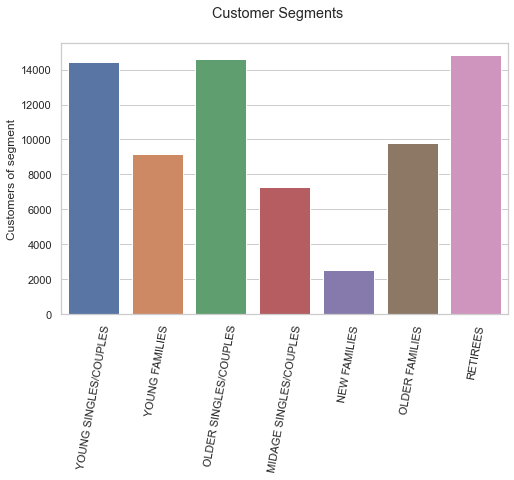

In [162]:
fig, axes = plt.subplots(1,1,figsize=(8,5))
fig.suptitle('Customer Segments')

sns.set_style("whitegrid")

sns.countplot(ax=axes,x=purchase_behav_df.LIFESTAGE, palette="deep").set(
    xlabel='', 
    ylabel='Customers of segment')


plt.xticks(rotation=80)
#plt.ylim(0, 150)
plt.show()

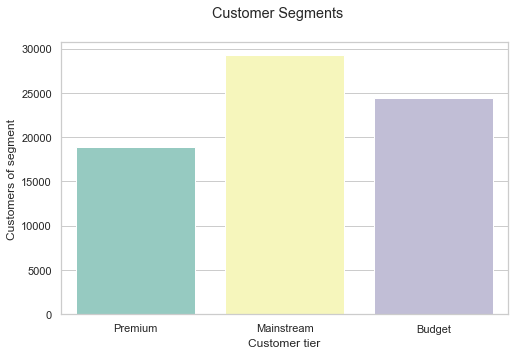

In [160]:
fig, axes = plt.subplots(1,1,figsize=(8,5))
fig.suptitle('Customer Segments')

sns.set_style("whitegrid")


sns.countplot(ax=axes,x=purchase_behav_df.PREMIUM_CUSTOMER, palette="Set3").set(
    xlabel='Customer tier', 
    ylabel='Customers of segment')
plt.xticks(rotation=0)
#plt.ylim(0, 150)
plt.show()

The purchase behaviour data is suitable for combining with the transaction data. It will allow us to get summary statistics on the general population.

In [138]:
joined_df = pd.merge(transaction_df_cleaned,purchase_behav_df, on = 'LYLTY_CARD_NBR')

In [139]:
joined_df.head()

,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES,BRAND,PACK_SIZE,LIFESTAGE,PREMIUM_CUSTOMER
0,2018-10-17,1,1000,1,5,natural chip compny g,2,6.0,Natural,[175],YOUNG SINGLES/COUPLES,Premium
1,2019-05-14,1,1307,348,66,ccs nacho cheese g,3,6.3,CCs,[175],MIDAGE SINGLES/COUPLES,Budget
2,2018-11-10,1,1307,346,96,ww original stacked chips g,2,3.8,Woolworths,[160],MIDAGE SINGLES/COUPLES,Budget
3,2019-03-09,1,1307,347,54,ccs original g,1,2.1,CCs,[175],MIDAGE SINGLES/COUPLES,Budget
4,2019-05-20,1,1343,383,61,smiths crinkle cut chips chicken g,2,2.9,Smiths,[170],MIDAGE SINGLES/COUPLES,Budget


In [140]:
joined_df.to_csv('data/QVI_combined_data.csv')

In [9]:
joined_df = pd.read_csv('data/QVI_combined_data.csv',index_col=0)

### Important customer data metrics

Now that we have combined transactions to customer data, we can relate factors such as:
- expenditure/TOT_SALES with LIFESTAGE and PREMIUM_CUSTOMER
- BRAND/product price with LIFESTAGE and PREMIUM_CUSTOMER
- characterisation of stores in terms of customer type

It would be interesting to know the proportion of the customer segments over the overall customer population, to understand if any segment is over-represented in the chips-buyers population; and their total expenditure figures, to see if chips are more prevalent for one of the segments.

In [3]:
#sales vs lifestage
s_ls_df = joined_df[['TOT_SALES','LIFESTAGE']]
s_ls_df = s_ls_df.groupby(['LIFESTAGE'], as_index=False).agg(TOT_SALES_mean=('TOT_SALES','mean'),
                                                             TOT_SALES_sum=('TOT_SALES','sum'))

In [4]:
s_ls_df

,LIFESTAGE,TOT_SALES_mean,TOT_SALES_sum
0,MIDAGE SINGLES/COUPLES,7.373442,172523.80
1,NEW FAMILIES,7.287664,47347.95
2,OLDER FAMILIES,7.274899,328519.90
3,OLDER SINGLES/COUPLES,7.402982,376019.65
4,RETIREES,7.373994,342381.90
5,YOUNG FAMILIES,7.275841,294627.90
6,YOUNG SINGLES/COUPLES,7.175854,243756.60


In [5]:
#sales vs premium segment
s_ps_df = joined_df[['TOT_SALES','PREMIUM_CUSTOMER']]
s_ps_df = s_ps_df.groupby(['PREMIUM_CUSTOMER'], as_index=False).agg(TOT_SALES_mean=('TOT_SALES','mean'),
                                                             TOT_SALES_sum=('TOT_SALES','sum'))
s_ps_df

,PREMIUM_CUSTOMER,TOT_SALES_mean,TOT_SALES_sum
0,Budget,7.277458,631406.85
1,Mainstream,7.374193,700865.40
2,Premium,7.282751,472905.45


In [6]:
# combined sales vs premium segment/lifestage
s_ls_ps_df = joined_df[['PREMIUM_CUSTOMER','LIFESTAGE','TOT_SALES']].groupby(['PREMIUM_CUSTOMER','LIFESTAGE'], as_index=False).agg(TOT_SALES_mean=('TOT_SALES','mean'),
                                                             TOT_SALES_sum=('TOT_SALES','sum'))
s_ls_ps_df

,PREMIUM_CUSTOMER,LIFESTAGE,TOT_SALES_mean,TOT_SALES_sum
0,Budget,MIDAGE SINGLES/COUPLES,7.108442,33345.70
1,Budget,NEW FAMILIES,7.297256,20607.45
2,Budget,OLDER FAMILIES,7.291241,156863.75
3,Budget,OLDER SINGLES/COUPLES,7.444305,127833.60
4,Budget,RETIREES,7.445786,105916.30
5,Budget,YOUNG FAMILIES,7.302705,129717.95
6,Budget,YOUNG SINGLES/COUPLES,6.663023,57122.10
7,Mainstream,MIDAGE SINGLES/COUPLES,7.637156,84734.25
8,Mainstream,NEW FAMILIES,7.313364,15979.70
9,Mainstream,OLDER FAMILIES,7.281440,96413.55


## Average and total expenditure per customer segment
This plot shows how customer segments (as combinations of LIFESTAGE and PREMIUM_CUSTOMER) are distributed in terms of average and total sales. **Colours** represents LIFESTAGE groups, whereas **marker shape** represents PREMIUM_CUSTOMER. 
Segments at the top of the plot have a high total expenditure, not depending on how large a segment is, while segments on the right side of the plot have a high mean expenditure.

In term of total sales, the segments contributing the most (over A$140k) are:
- Budget, older families;
- Mainstream, young singles/couples;
- Mainstream, retirees;

If we compare that to the number of customers per segment, we can see these three segments are the three most represented ones.
In terms of average sale expenditure, mainstream, midage singles/couples have the highest figure.  
These would be my main indication in terms of segments to be targeted. If we were to expand our target, including other segments, then I would add Premium and Budget Older Singles/Couples, which do well in terms of average and total expenditure, and are one of the most represented segments.

We can verify if customer behaviour can be described in terms of average number of products and product price.

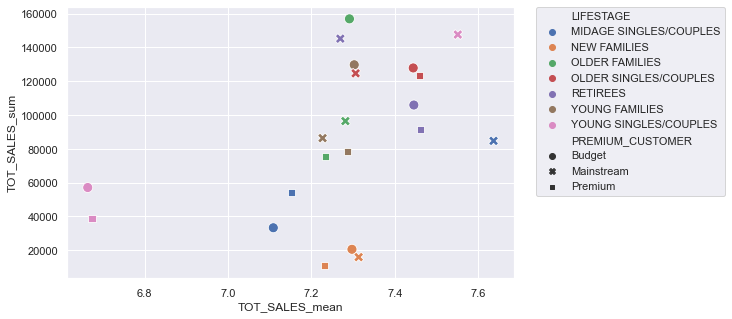

In [7]:
fig, axes = plt.subplots(1,1,figsize=(8,5))
sns.scatterplot(ax = axes, data=s_ls_ps_df, x='TOT_SALES_mean',y='TOT_SALES_sum',hue = 'LIFESTAGE',style='PREMIUM_CUSTOMER',s=100)
sns.set_theme()
plt.setp(axes.get_legend().get_title(), fontsize='50') # for legend title
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

In [69]:
segment_size_df=joined_df.groupby(['PREMIUM_CUSTOMER','LIFESTAGE']).size().reset_index().rename(columns={0:'count'})

segment_size_df

,PREMIUM_CUSTOMER,LIFESTAGE,count
0,Budget,MIDAGE SINGLES/COUPLES,4691
1,Budget,NEW FAMILIES,2824
2,Budget,OLDER FAMILIES,21514
3,Budget,OLDER SINGLES/COUPLES,17172
4,Budget,RETIREES,14225
5,Budget,YOUNG FAMILIES,17763
6,Budget,YOUNG SINGLES/COUPLES,8573
7,Mainstream,MIDAGE SINGLES/COUPLES,11095
8,Mainstream,NEW FAMILIES,2185
9,Mainstream,OLDER FAMILIES,13241


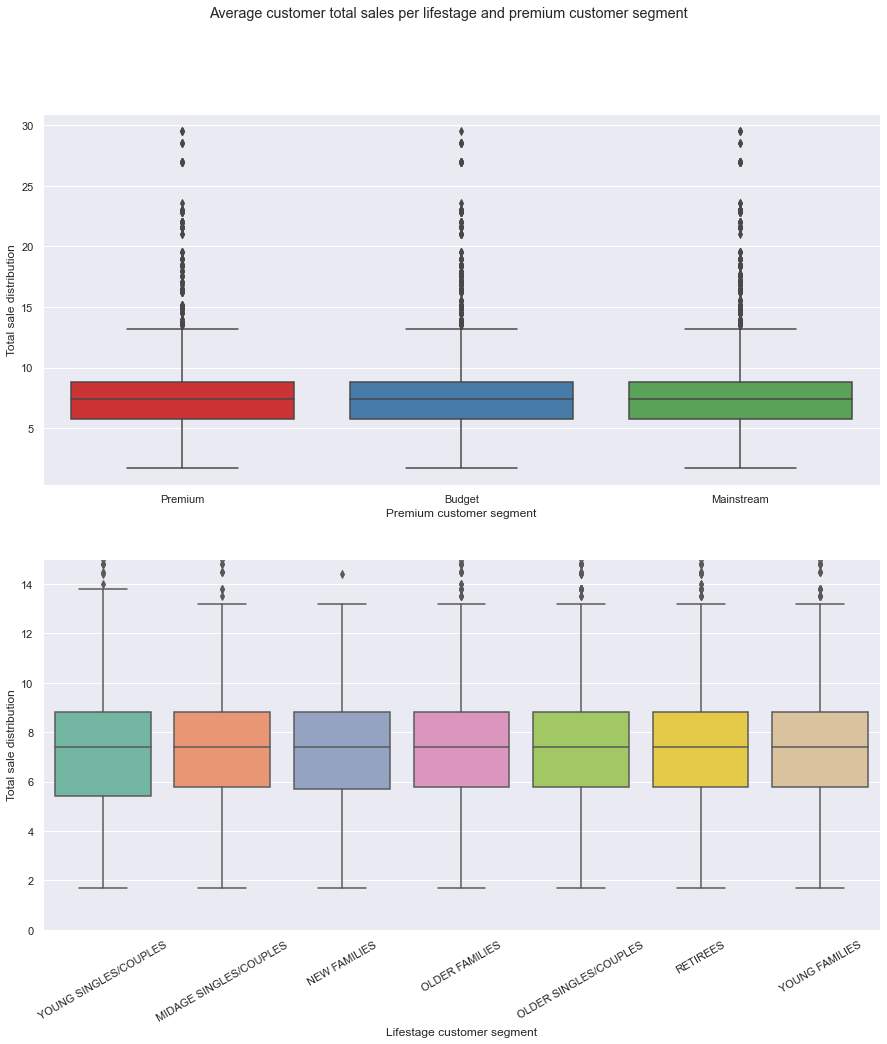

In [10]:
fig, axes = plt.subplots(2,1,figsize=(15,15))
fig.suptitle('Average customer total sales per lifestage and premium customer segment')

sns.set_style("whitegrid")
plt.xticks(rotation=30)
sns.boxplot(ax=axes[0],x='PREMIUM_CUSTOMER',y='TOT_SALES',data=joined_df, palette="Set1").set(
    xlabel='Premium customer segment', 
    ylabel='Total sale distribution')
sns.boxplot(ax=axes[1],x='LIFESTAGE',y='TOT_SALES',data=joined_df, palette="Set2").set(
    xlabel='Lifestage customer segment', 
    ylabel='Total sale distribution')
plt.ylim(0, 15)

plt.show()

## Average number of products and product price per segment

In [67]:
# avg prod number and prod price vs customer segment
pn_ps_cs_df = joined_df[['PREMIUM_CUSTOMER','LIFESTAGE','TOT_SALES','PROD_QTY']].groupby(['PREMIUM_CUSTOMER','LIFESTAGE'], as_index=False).agg(TOT_SALES_mean=('TOT_SALES','mean'),
                                                            TOT_SALES_std=('TOT_SALES','std'),
                                                            PROD_QTY_mean=('PROD_QTY','mean'),
                                                            PROD_QTY_std = ('PROD_QTY','std'))
pn_ps_cs_df['PROD_PRICE_mean'] = pn_ps_cs_df.apply(lambda row: row.TOT_SALES_mean/row.PROD_QTY_mean, axis=1)

pn_ps_cs_df['PROD_PRICE_std'] = pn_ps_cs_df.apply(lambda x: x.PROD_PRICE_mean * sqrt((x.TOT_SALES_std/x.TOT_SALES_mean)**2 + (x.PROD_QTY_std/x.PROD_QTY_mean)**2), axis=1)

pn_ps_cs_df

,PREMIUM_CUSTOMER,LIFESTAGE,TOT_SALES_mean,TOT_SALES_std,PROD_QTY_mean,PROD_QTY_std,PROD_PRICE_mean,PROD_PRICE_std
0,Budget,MIDAGE SINGLES/COUPLES,7.108442,2.515738,1.893626,0.360620,3.753878,1.508658
1,Budget,NEW FAMILIES,7.297256,2.512455,1.855878,0.376583,3.931969,1.571397
2,Budget,OLDER FAMILIES,7.291241,2.441361,1.945384,0.295838,3.747969,1.378317
3,Budget,OLDER SINGLES/COUPLES,7.444305,2.442219,1.914920,0.325270,3.887529,1.436175
4,Budget,RETIREES,7.445786,2.490583,1.893286,0.352559,3.932731,1.505591
5,Budget,YOUNG FAMILIES,7.302705,2.438325,1.941226,0.305215,3.761903,1.388369
6,Budget,YOUNG SINGLES/COUPLES,6.663023,2.634132,1.808002,0.429594,3.685297,1.699827
7,Mainstream,MIDAGE SINGLES/COUPLES,7.637156,2.413133,1.911942,0.335261,3.994449,1.443466
8,Mainstream,NEW FAMILIES,7.313364,2.518599,1.858124,0.375545,3.935887,1.571637
9,Mainstream,OLDER FAMILIES,7.281440,2.418931,1.948795,0.300212,3.736380,1.368207


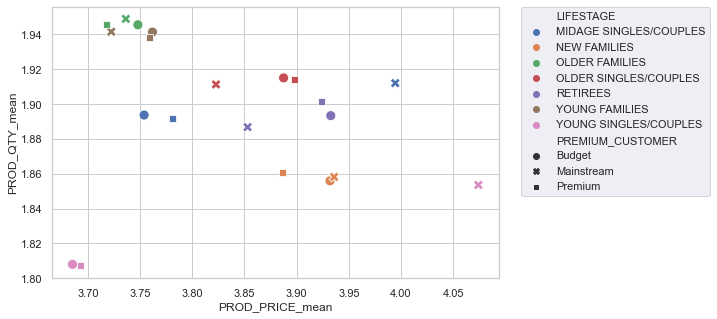

In [12]:
fig, axes = plt.subplots(1,1,figsize=(8,5))
sns.scatterplot(ax = axes, data=pn_ps_cs_df, x='PROD_PRICE_mean',y='PROD_QTY_mean',hue = 'LIFESTAGE',style='PREMIUM_CUSTOMER',s=100)
sns.set_theme()
plt.setp(axes.get_legend().get_title(), fontsize='50') # for legend title
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

This is interesting: we can clearly see customer segmentation here, in clearer way than before. Segments of a same LIFESTAGE category tend to behave in a similar way, and form recognisable clusters. Amongst the targeted segments:

- Budget, older families: buying high quantity, low price;
- Mainstream, young singles/couples: buying low quantity, high price;
- Mainstream, retirees: buying average quantity, average price.

It is really interesting to see how the three groups sit on the extremes of customer behaviour. This probably represents different habits influenced by culture and demographics, such as frequency of use, purchase for social gatherings, healthy eating habits, etc.

It is important however to take the differences between the extremes of average price and quantity with some caution, as they are not large in relative terms (9.5% on average price, 7% on average quantity). To check that the difference is statistically significant, I am running a t-test, using the desdicated functions in the SciPy package. Given the relative magnitude of standard deviation of the quantities of interesting, I am curious to see if differences are significant.

In [71]:
#Select the populations
#PROD_PRICE_mean: budget young singles/couples VS mainstream young singles/couples
#budget young singles/couples
mean1 = float(pn_ps_cs_df[[pn_ps_cs_df.PREMIUM_CUSTOMER[i] == 'Budget' and 
                            pn_ps_cs_df.LIFESTAGE[i] == 'YOUNG SINGLES/COUPLES' 
                            for i in range(len(pn_ps_cs_df))]]['PROD_PRICE_mean'])
std1 = float(pn_ps_cs_df[[pn_ps_cs_df.PREMIUM_CUSTOMER[i] == 'Budget' and 
                            pn_ps_cs_df.LIFESTAGE[i] == 'YOUNG SINGLES/COUPLES' 
                            for i in range(len(pn_ps_cs_df))]]['PROD_PRICE_std'])
nobs1 = int(segment_size_df[[segment_size_df.PREMIUM_CUSTOMER[i] == 'Budget' and 
                            segment_size_df.LIFESTAGE[i] == 'YOUNG SINGLES/COUPLES' 
                            for i in range(len(segment_size_df))]]['count'])
#mainstream young singles/couples
mean2 = float(pn_ps_cs_df[[pn_ps_cs_df.PREMIUM_CUSTOMER[i] == 'Mainstream' and 
                            pn_ps_cs_df.LIFESTAGE[i] == 'YOUNG SINGLES/COUPLES' 
                            for i in range(len(pn_ps_cs_df))]]['PROD_PRICE_mean'])
std2 = float(pn_ps_cs_df[[pn_ps_cs_df.PREMIUM_CUSTOMER[i] == 'Mainstream' and 
                            pn_ps_cs_df.LIFESTAGE[i] == 'YOUNG SINGLES/COUPLES' 
                            for i in range(len(pn_ps_cs_df))]]['PROD_PRICE_std'])
nobs2 = int(segment_size_df[[segment_size_df.PREMIUM_CUSTOMER[i] == 'Mainstream' and 
                            segment_size_df.LIFESTAGE[i] == 'YOUNG SINGLES/COUPLES' 
                            for i in range(len(segment_size_df))]]['count'])

scipy.stats.ttest_ind_from_stats(mean1, std1, nobs1, mean2, std2, nobs2, equal_var=False, alternative='less')

Ttest_indResult(statistic=-18.056646761661835, pvalue=1.9660710445429456e-72)

In [20]:
# MANUAL IMPLEMENTATION

se1 = std1/sqrt(nobs1)
se2 = std2/sqrt(nobs2)
sed = sqrt(se1**2.0 + se2**2.0)
df = nobs1 + nobs2 - 2

t_stat = (mean1 - mean2) / sed

# calculate the critical value
alpha = 0.1
cv = scipy.stats.t.ppf(1.0 - alpha, df)

# calculate the p-value
p = (1 - scipy.stats.t.cdf(abs(t_stat), df)) * 2

print('t_stat:',t_stat,'; cv:',cv,'; p:',p )

t_stat: -18.056646761661835 ; cv: 1.2815816777648745 ; p: 0.0


The test shows that the results are significant in this case. What about the differences in product quantity?

In [21]:
#Select the populations
#PROD_QTY_mean: mainstream older families VS budget young singles/couples
#budget young singles/couples
mean1 = float(pn_ps_cs_df[[pn_ps_cs_df.PREMIUM_CUSTOMER[i] == 'Budget' and 
                            pn_ps_cs_df.LIFESTAGE[i] == 'YOUNG SINGLES/COUPLES' 
                            for i in range(len(pn_ps_cs_df))]]['PROD_QTY_mean'])
std1 = float(pn_ps_cs_df[[pn_ps_cs_df.PREMIUM_CUSTOMER[i] == 'Budget' and 
                            pn_ps_cs_df.LIFESTAGE[i] == 'YOUNG SINGLES/COUPLES' 
                            for i in range(len(pn_ps_cs_df))]]['PROD_QTY_std'])
nobs1 = int(segment_size_df[[segment_size_df.PREMIUM_CUSTOMER[i] == 'Budget' and 
                            segment_size_df.LIFESTAGE[i] == 'YOUNG SINGLES/COUPLES' 
                            for i in range(len(segment_size_df))]]['count'])
#mainstream OLDER FAMILIES
mean2 = float(pn_ps_cs_df[[pn_ps_cs_df.PREMIUM_CUSTOMER[i] == 'Mainstream' and 
                            pn_ps_cs_df.LIFESTAGE[i] == 'OLDER FAMILIES' 
                            for i in range(len(pn_ps_cs_df))]]['PROD_QTY_mean'])
std2 = float(pn_ps_cs_df[[pn_ps_cs_df.PREMIUM_CUSTOMER[i] == 'Mainstream' and 
                            pn_ps_cs_df.LIFESTAGE[i] == 'OLDER FAMILIES' 
                            for i in range(len(pn_ps_cs_df))]]['PROD_QTY_std'])
nobs2 = int(segment_size_df[[segment_size_df.PREMIUM_CUSTOMER[i] == 'Mainstream' and 
                            segment_size_df.LIFESTAGE[i] == 'OLDER FAMILIES' 
                            for i in range(len(segment_size_df))]]['count'])

scipy.stats.ttest_ind_from_stats(mean1, std1, nobs1, mean2, std2, nobs2, equal_var=True, alternative='less')

Ttest_indResult(statistic=-28.47332809400725, pvalue=1.9900798616542437e-175)

## **Replicating test from solution**

Following review of th solution, I understood the error of interpretation of the test on my part. A small p represents the probablilty of the null hypothesis, i.e. that the means of the two populations are equal. Hence the results obtained are significant in highlighting a difference in product quantity and average price between extremes in customer segments.

In [74]:
#Select the populations
#PROD_QTY_mean: mainstream MIDAGE SINGLES/COUPLES VS mainstream young singles/couples
#mainstream MIDAGE SINGLES/COUPLES
mean1 = float(pn_ps_cs_df[[pn_ps_cs_df.PREMIUM_CUSTOMER[i] == 'Mainstream' and 
                            pn_ps_cs_df.LIFESTAGE[i] == 'MIDAGE SINGLES/COUPLES' 
                            for i in range(len(pn_ps_cs_df))]]['PROD_PRICE_mean'])
std1 = float(pn_ps_cs_df[[pn_ps_cs_df.PREMIUM_CUSTOMER[i] == 'Mainstream' and 
                            pn_ps_cs_df.LIFESTAGE[i] == 'MIDAGE SINGLES/COUPLES' 
                            for i in range(len(pn_ps_cs_df))]]['PROD_PRICE_std'])
nobs1 = int(segment_size_df[[segment_size_df.PREMIUM_CUSTOMER[i] == 'Mainstream' and 
                            segment_size_df.LIFESTAGE[i] == 'MIDAGE SINGLES/COUPLES' 
                            for i in range(len(segment_size_df))]]['count'])
#mainstream OLDER FAMILIES
mean2 = float(pn_ps_cs_df[[pn_ps_cs_df.PREMIUM_CUSTOMER[i] == 'Mainstream' and 
                            pn_ps_cs_df.LIFESTAGE[i] == 'YOUNG SINGLES/COUPLES' 
                            for i in range(len(pn_ps_cs_df))]]['PROD_PRICE_mean'])
std2 = float(pn_ps_cs_df[[pn_ps_cs_df.PREMIUM_CUSTOMER[i] == 'Mainstream' and 
                            pn_ps_cs_df.LIFESTAGE[i] == 'YOUNG SINGLES/COUPLES' 
                            for i in range(len(pn_ps_cs_df))]]['PROD_PRICE_std'])
nobs2 = int(segment_size_df[[segment_size_df.PREMIUM_CUSTOMER[i] == 'Mainstream' and 
                            segment_size_df.LIFESTAGE[i] == 'YOUNG SINGLES/COUPLES' 
                            for i in range(len(segment_size_df))]]['count'])

scipy.stats.ttest_ind_from_stats(mean1, std1, nobs1, mean2, std2, nobs2, equal_var=False, alternative='less')

Ttest_indResult(statistic=-4.489813025419542, pvalue=3.580397714626358e-06)

### Most common brand and pack size per segment

In [57]:
joined_df[['PREMIUM_CUSTOMER','LIFESTAGE','PROD_NBR','PROD_NAME','BRAND' ,'PACK_SIZE']].groupby(['PREMIUM_CUSTOMER','LIFESTAGE'], as_index=False).agg(
                                                            PROD_NBR_mode=('PROD_NBR',lambda x: x.value_counts().index[0]),
                                                            PROD_NAME_mode=('PROD_NAME',lambda x: x.value_counts().index[0]),
                                                            BRAND_mode=('BRAND',lambda x: x.value_counts().index[0]),
                                                            PACK_SIZE_mode=('PACK_SIZE',lambda x: x.value_counts().index[0])
                                                            )

,PREMIUM_CUSTOMER,LIFESTAGE,PROD_NBR_mode,PROD_NAME_mode,BRAND_mode,PACK_SIZE_mode
0,Budget,MIDAGE SINGLES/COUPLES,31,kettle tortilla g,Kettle,['175']
1,Budget,NEW FAMILIES,88,kettle tortilla g,Kettle,['175']
2,Budget,OLDER FAMILIES,16,kettle tortilla g,Kettle,['175']
3,Budget,OLDER SINGLES/COUPLES,75,kettle tortilla g,Kettle,['175']
4,Budget,RETIREES,36,kettle tortilla g,Kettle,['175']
5,Budget,YOUNG FAMILIES,24,kettle tortilla g,Kettle,['175']
6,Budget,YOUNG SINGLES/COUPLES,81,kettle tortilla g,Kettle,['175']
7,Mainstream,MIDAGE SINGLES/COUPLES,16,kettle tortilla g,Kettle,['175']
8,Mainstream,NEW FAMILIES,63,kettle tortilla g,Kettle,['175']
9,Mainstream,OLDER FAMILIES,2,kettle tortilla g,Kettle,['175']


In [59]:
#Feel free to verify
joined_df[[joined_df.PREMIUM_CUSTOMER[i] == 'Budget' and 
                            joined_df.LIFESTAGE[i] == 'RETIREES' 
                            for i in range(len(joined_df))]]['PROD_NAME'].value_counts().index[0]

'kettle tortilla g'

In [60]:
#Feel free to verify
joined_df[[joined_df.PREMIUM_CUSTOMER[i] == 'Budget' and 
                            joined_df.LIFESTAGE[i] == 'RETIREES' 
                            for i in range(len(joined_df))]]['PROD_NBR'].value_counts().index[0]

36

It looks like all segments prefer Kettle chips, and packs of 175 g.  
It's not clear to me how the most common name is the same, but the product number is not, assuming a univocal correspondece. We can verify that by creating a product number to name look up table:

In [89]:
plu=joined_df[['PROD_NBR','PROD_NAME']]
plu.value_counts().sort_index()

PROD_NBR  PROD_NAME                          
1         smiths crinkle cut chips barbecue g    1489
2         cobs popd sour crm chives chips g      3159
3         kettle sensations camembert fig g      3219
4         dorito corn chp supreme g              3183
5         natural chip compny g                  1468
                                                 ... 
110       ww original corn chip g                1495
111       smiths chip thinly cut original g      1614
112       tyrrells crisps ched chive g           3268
113       twistie g                              3170
114       kettle sensations siracha lime g       3127
Length: 105, dtype: int64

and then verify:

In [54]:
#index is product number
product_look_up.loc[36]

PROD_NAME
kettle chilli g    3038
dtype: int64

There seems to be a mismatch between most common product name and most common product number, which can probably be explained with the fact that different product numbers share the same name (after being cleaned of numbers), which would occur for instance for packages of same product but different size.

In [90]:
plu[[plu['PROD_NAME'][i]=='kettle tortilla g' for i in range(len(plu))]].value_counts()

PROD_NBR  PROD_NAME        
9         kettle tortilla g    3146
60        kettle tortilla g    3138
dtype: int64

There you go! easily demonstrated.  
To gain further insights on the data, I am going to perform a market basket analysis (MBA) for one of the target segments: budget, older families.

### Market Basket Analysis
MBA helps us identify customer preferences. There are two ways about this:
- grouping items by transaction, using the TXN_ID field, thus getting an indications of items that are commonly bought together;
- grouping items by customer LYLTY_CARD_NBR, getting an indication of individual customer's (or their family's) taste at a general level;
- grouping items by customer segment, getting an indication of preferences at a customer segment level.

I am performing a MBA grouping by transaction, as the most literal version of MBA. Other ways of grouping can be very insightful and useful in a recommender system scenario; the reader can easily implement them with slight changes to my code.

(Reference: https://pythondata.com/market-basket-analysis-with-python-and-pandas/)

**MBA, grouping by transaction**

In [26]:
mba_segment_df = joined_df[[joined_df.PREMIUM_CUSTOMER[i] == 'Budget' and 
                            joined_df.LIFESTAGE[i] == 'OLDER FAMILIES' 
                            for i in range(len(joined_df))]].groupby(
                            ['TXN_ID', 'PROD_NAME'])['PROD_QTY']

In [27]:
mba_segment_df = mba_segment_df.sum().unstack().reset_index().fillna(0).set_index('TXN_ID')

In [30]:
mba_segment_df.head()

PROD_NAME,burger rings g,cc tasty cheese g,ccs nacho cheese g,ccs original g,cheetos chs bacon balls g,cheetos puffs g,cheezels cheese box g,cheezels cheese g,cobs popd sea salt chips g,cobs popd sour crm chives chips g,...,tyrrells crisps ched chive g,tyrrells crisps lightly salt g,woolworths cheese ring g,ww crinkle cut chicken g,ww crinkle cut original g,ww d style chip sea salt g,ww original corn chip g,ww original stacked chips g,ww sour cream onionstacked chips g,ww supreme cheese corn chip g
TXN_ID,,,,,,,,,,,,,,,,,,,,,
29,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
103,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
117,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
118,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
157,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [32]:
# Values in dataframe have to be either 0 or 1, so we have to convert not null numbers to 1.
def encode_data(datapoint):
    if datapoint <= 0:
        return 0
    if datapoint >= 1:
        return 1
mba_segment_df = mba_segment_df.applymap(encode_data)

In [61]:
itemsets = apriori(mba_segment_df, min_support=0.00005, use_colnames=True)

An issue here is that the dataframe is very sparse, and absolute values of occureency are very low. Hence we need to specify a very low value of _min_support_, which represents how frequent the item appears in the dataset.

In [64]:
rules = association_rules(itemsets, metric="lift", min_threshold=0.5)

The choice of metric to assess the relationship between antecedents and consequents implies slightly different relationships (see http://rasbt.github.io/mlxtend/user_guide/frequent_patterns/association_rules/ for reference). I have chosen _lift_, as it gives an idea on how much more often the antecedent and consequent occur together than we would expect if they were statistically independent. If they are independent, lift=1. 

In [65]:
rules

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(burger rings g),(pringles chicken salt crips g),0.007457,0.010787,0.000094,0.012579,1.166092,0.000013,1.001814
1,(pringles chicken salt crips g),(burger rings g),0.010787,0.007457,0.000094,0.008696,1.166092,0.000013,1.001249
2,(doritos corn chip nacho cheese g),(cheezels cheese g),0.011068,0.012897,0.000094,0.008475,0.657072,-0.000049,0.995539
3,(cheezels cheese g),(doritos corn chip nacho cheese g),0.012897,0.011068,0.000094,0.007273,0.657072,-0.000049,0.996177
4,(doritos corn chip cheese supreme g),(doritos corn chip southern chicken g),0.013320,0.011772,0.000094,0.007042,0.598227,-0.000063,0.995237
5,(doritos corn chip southern chicken g),(doritos corn chip cheese supreme g),0.011772,0.013320,0.000094,0.007968,0.598227,-0.000063,0.994606
6,(smith thinly cut roast chicken g),(smiths crinkle cut g),0.007176,0.006754,0.000094,0.013072,1.935548,0.000045,1.006402
7,(smiths crinkle cut g),(smith thinly cut roast chicken g),0.006754,0.007176,0.000094,0.013889,1.935548,0.000045,1.006808


Here are the conclusions of my analysis. Note that the products come in couples but metrics value are not symmetrical, as they depend on each item's support within the data. 